In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from IPython.display import display
from scipy.optimize import differential_evolution
from scipy.optimize import minimize

In [2]:
# Helper functions
def delta (i, j) :
    if i==j :
        return 1
    else :
        return 0
  
def secondDerivative (i, j, fun, params) :
    stepi = 0.001*abs(params[i]) + 1e-10
    stepj = 0.001*abs(params[j] ) + 1e-10
    parplusplus = params.copy()
    parplusminus = params.copy()
    parminusplus = params.copy()
    parminusminus = params.copy()
    parplusplus[i] = parplusplus[i] + stepi
    parplusplus[j] = parplusplus[j] + stepj
    parplusminus[i] = parplusminus[i] + stepi
    parplusminus[j] = parplusminus[j] - stepj 
    parminusplus[i] = parminusplus[i] - stepi
    parminusplus[j] = parminusplus[j] + stepj
    parminusminus[i] = parminusminus[i] - stepi
    parminusminus[j] = parminusminus[j] - stepj
    ret = (1/(4*stepi*stepj)) * (fun(parplusplus)+ fun(parminusminus) - fun(parplusminus)- fun(parminusplus))
    return ret
    
def getHessian(fun, params) : 
    dim = len(params)
    hess = np.zeros([dim,dim])
    for i in range(dim) :
        for j in range(dim) :
            hess[i][j] = secondDerivative(i, j, fun, params)/2.0
    #print(hess)
    return hess
    

In [3]:
class DatasetGenerator :
    ''' 
    argument : 
    - theoryParams : list of theory parameter
    - theoryPrediction : a function (double x, List(double))
    - xGrid : list of x 
    - stats : list of the statistical error
    - systFluct : list of systematic fluctuation 
    - **syst : dictionary of systematicfluctuation
    '''
    def __init__(self, theoryParams, theoryPredictions, xGrid, stats, systFluct, *syst) : #dataPd must of the form numpy array: xGrid , data
        self.theoryParams = theoryParams # theory params
        self.xGrid = np.array(xGrid) # grid of x
        self.statsSpread = np.array(stats)  #statistical error
        self.systFluct = np.array(systFluct) #systeatic fluctuation
        self.theoryPredictions = theoryPredictions #theory prediction        
        self.systSpread= np.array([sys for sys in syst]) #systematic error 
        self.syst= np.array([self.systFluct[i]*self.systSpread[i] for i in range(len(self.systSpread))])# systematic fluctuation * systematic error
        self.stats = np.array([np.random.normal()*el for el in self.statsSpread])
        self.numSyst = len(self.systSpread)
        self.numData = len(xGrid)
        assert (len(xGrid) == len(self.statsSpread))
        assert (len(self.systFluct) == len(self.systSpread)) 
        print ("Real statistical error : ", self.stats)
        print ("Real systematic error : ", self.syst)
        self.totErr = []
        for i in range(len(xGrid)) :
            c = self.statsSpread[i]**2
            for sys in self.systSpread: 
                c = c+ sys[i]**2
            self.totErr.append(c**(0.5))            
        self.generateDataset()
        self.getCovarianceMatrix()
        
        plt.figure()
        plt.errorbar(self.xGrid, self.data, self.totErr, linestyle=" ", marker= "o", label="Data" )
        plt.plot(self.xGrid, self.theo, label="Generator")
        plt.show()

    
    def generateData (self) :
        self.theo = np.array([self.theoryPredictions(x, self.theoryParams) for x in self.xGrid ]  )
        self.data = self.theo + self.stats
        for syst in self.syst :
            self.data = self.data + syst
        return self.data
        
    def generateDataset(self) :
        self.generateData()
        self.dataset= [self.xGrid, self.data, self.theo, self.statsSpread] #xGrid, data, theo, stats, syst
        cols = ["x", "data", "theory", "stats" ]
        for i in range(self.numSyst):
            self.dataset.append(self.systSpread[i])
            cols.append("syst_"+str(i))       
        #print(np.array(self.dataset))
        self.dataDF = pd.DataFrame(np.array(self.dataset).T, columns= cols)
        display(self.dataDF)
        
    def generateReplica(self) :
        stat = np.array([np.random.normal()*el for el in self.statsSpread])
        systFluct = np.array([np.random.normal() for i in range(self.numSyst)])
        #print("syt fluct : ", systFluct)
        syst = np.array([systFluct[i]*self.systSpread[i] for i in range(self.numSyst)])
        data = self.theo + stat
        for i in range(self.numSyst) :
            data = data + syst[i]
        return data 
    
    def generateReplicaFromData(self) :
        stat = np.array([np.random.normal()*el for el in self.statsSpread])
        systFluct = np.array([np.random.normal() for i in range(self.numSyst)])
        #print("syt fluct : ", systFluct)
        syst = np.array([systFluct[i]*self.systSpread[i] for i in range(self.numSyst)])
        data = self.data + stat
        for i in range(self.numSyst) :
            data = data + syst[i]
        return data 
    
    def getCovarianceMatrix (self):
        self.corr = np.zeros([self.numData,self.numData])
        for i in range(self.numData) :
            for j in range(self.numData) :
                systcorr= 0.0
                for a in range(self.numSyst) :
                    systcorr = systcorr + self.systSpread[a][i]*self.systSpread[a][j]
                self.corr[i, j] =  delta(i,j)*(self.statsSpread[i]**2)+ systcorr      
        self.corrInv = np.linalg.inv(self.corr) 


class ChiSquare :   
    def __init__(self, dataGenerator, theoryPredictions):
        self.dataGen = dataGenerator
        self.theo = theoryPredictions
        self.data = self.dataGen.data
        self.xGrid = self.dataGen.xGrid
        self.numPoints = len(self.dataGen.xGrid)
        self.getCovarianceMatrix()
                
    def getCovarianceMatrix (self): #pure virtual function
        raise NotImplementedError                  
                    
    def chi2(self, params):#pure virtual function
        raise NotImplementedError       

            
class ChiSquareCorr (ChiSquare):
    def __init__(self, dataGenerator, theoryPredictions, useCorr = True):
        self.useCorr = useCorr
        super().__init__(dataGenerator, theoryPredictions)
        
    def getCovarianceMatrix (self):
        self.corr = self.dataGen.corr
        self.corrInv = self.dataGen.corrInv
        if not self.useCorr : #if correlation is ignored
            for i in range(self.numPoints ) :
                for j in range(self.numPoints ) :
                    if (i != j) :
                        self.corr[i][j] = 0.0
                        self.corrInv[i][j] = 0.0                        
                    
    def chi2(self, theoryParams):
        theory = np.array([self.theo(x, theoryParams) for x in self.xGrid])
        chi2 = np.dot( (self.data-theory), np.dot(self.corrInv, (self.data-theory)))
        return chi2
     

class ChiSquareCorrFit (ChiSquare):
    def __init__(self, dataGenerator, theoryPredictions, numTheoParam):
        super().__init__(dataGenerator, theoryPredictions)  
        self.numTheoParams = numTheoParam 

    def getCovarianceMatrix (self):
        self.corr = np.diag(np.array([sig**2 for sig in self.dataGen.statsSpread ]))
        self.corrInv = np.diag(np.array([1/(sig**2) for sig in self.dataGen.statsSpread]))                
                    
    def chi2(self, params):
        theoparams = np.array([params[i] for i in range(self.numTheoParams)])
        corrParams = np.array([params[i] for i in range(self.numTheoParams, self.numTheoParams + self.dataGen.numSyst )])
        theory = np.array([self.theo(x, params) for x in xGrid])
        residual = self.data-theory
        for i in range (self.dataGen.numSyst) :
            residual = residual - corrParams[i] * self.dataGen.systSpread[i]
        chi2 = np.dot( residual, np.dot(self.corrInv, residual)) + np.dot(corrParams, corrParams)
        return chi2



class GlobalAnalysis :
    def __init__(self,tol,  *chisqr ):
        self.chisqrs = [chi2 for chi2 in chisqr]
        self.tol = tol
        self.theoXGrid = np.logspace(-3,-0.0000000001,200)
        
    def chi2(self, params):
        totalchi2 = 0
        for Chi2 in self.chisqrs : 
            totalchi2 = totalchi2 + Chi2.chi2(params)
        return totalchi2            
    
    def runFit (self, bounds):
        self.numParams = len(bounds)
        result = differential_evolution(self.chi2, bounds)
        self.parAtMin = result.x
        self.funAtMin = result.fun
        print ("Parameter at minimum : ", result.x)
        print ("Chisqr at minimum : ", result.fun)  
        print ("Chisqr per dof : ", result.fun/(self.getNumberOfPoints()-self.numParams))
        self.getParameterError()
        self.plotDataTheory()
    
    def plotDataTheory(self) :
        self.getTheoryError()
        for i, Chi2 in zip(range(len(self.chisqrs)), self.chisqrs) : 
            #print(self.theoError[i])
            newtheo = np.array([Chi2.theo(x, self.parAtMin) for x in self.theoXGrid])
            trueTheo = np.array([Chi2.dataGen.theoryPredictions(x, Chi2.dataGen.theoryParams) for x in self.theoXGrid])
            data = Chi2.dataGen.data           
            plt.figure()
            plt.errorbar(Chi2.dataGen.xGrid, data, Chi2.dataGen.totErr, linestyle=" ", marker= "o", label="Data" )
            #plt.scatter (self.xGrid, self.data)
            plt.fill_between(self.theoXGrid,newtheo+self.theoError[i], newtheo-self.theoError[i], color="red", alpha=0.2)
            plt.plot(self.theoXGrid, newtheo, color="red", label="Fit")
            plt.plot(self.theoXGrid,  trueTheo, color="blue", label="True Theory")
            plt.legend(fontsize=10)
            plt.show()
            
        
    def getNumberOfPoints (self):
        self.numPoints = 0
        for Chi2 in self.chisqrs : 
               self.numPoints = self.numPoints + Chi2.numPoints
        return self.numPoints
    
    def getTheoryError(self) :
        self.theoError = []
        for Chi2 in self.chisqrs : 
            theoErrori = [0.5* (np.sum(np.array([ (Chi2.theo(x, self.errorParams[2*i])-Chi2.theo(x, self.errorParams[2*i+1]))**2 for i in range(self.numParams)])))**(0.5)
                          for x in self.theoXGrid]
            self.theoError.append(np.array(theoErrori))
    
    def getParameterError(self):       
        self.hessian = getHessian(self.chi2, self.parAtMin)
        self.eigVals, self.eigVecs = np.linalg.eig(self.hessian)
        for eig in self.eigVals :
                if eig < 0.0 : 
                    print ("Warning : negative eigenvalue : ", eig)
        self.eigVals = np.abs(self.eigVals)
        self.transMat = np.dot(self.eigVecs, np.diag(np.array([eig**(-0.5) for eig in self.eigVals])))           
        
        #print("Hessian : \n", self.hessian)
        #print("Eigenvalus : \n", self.eigVals)
        #print("EigenVectors : \n", self.eigVecs)
        #print("TransMat : \n", self.transMat)
        
        t = self.tol**(1/2)
        self.errorParams = []
        for i in range(self.numParams) :
            self.errorParams.append(self.parAtMin + t*self.transMat[:,i])
            self.errorParams.append(self.parAtMin - t*self.transMat[:,i])
        
        hessInv = np.linalg.inv(self.hessian)
        err = [hessInv[i, i] for i in range(self.numParams)]
        print("Parameter error using hessian method : \n", self.tol**(0.5)*np.sqrt(err) )
        
        
            
    
    def chi2Replicas(self, params):
        mytheo = [ np.array([Chi2.theo(x, params) for x in Chi2.dataGen.xGrid]) for Chi2 in self.chisqrs]
        mychi2 = np.sum(np.array(  [ np.dot( (self.mydata[i]-mytheo[i]),
                                            np.dot(self.chisqrs[i].corrInv, (self.mydata[i]-mytheo[i]))) for i in range(len(self.chisqrs)) ] ))
        return mychi2
        
    def runReplicaFits(self, bounds, N, useTrueTheo=True) :
        self.parAtMinRep = []
        self.funAtMinRep = []
        self.z = []
        for i in range(N) : 
            if (useTrueTheo) :
                self.mydata = [Chi2.dataGen.generateReplica() for Chi2 in self.chisqrs] 
            else : 
                self.mydata = [Chi2.dataGen.generateReplicaFromData() for Chi2 in self.chisqrs]                
            result = differential_evolution(self.chi2Replicas, bounds)
            self.parAtMinRep.append(result.x)
            self.funAtMinRep.append(result.fun)
            hess = getHessian(self.chi2Replicas, result.x)
            eigVals, eigVecs = np.linalg.eig(hess)
            for eig in eigVals :
                if eig < 0.0 : 
                    print ("Warning : negative eigenvalue : ", eig)
            eigVals = np.abs(eigVals)
            transMatinv = np.dot(np.diag(np.array([ eig**(1/2) for eig in eigVals])), eigVecs.T)
            delta = np.array(result.x) - np.array(self.chisqrs[0].dataGen.theoryParams)
            self.z.append(np.dot(transMatinv, delta))
             
            for Chi2 in self.chisqrs : 
                newtheo = [Chi2.theo(x, result.x) for x in Chi2.dataGen.xGrid]
                data = self.mydata
                '''
                plt.scatter (Chi2.dataGen.xGrid, data)
                plt.plot(Chi2.dataGen.xGrid, newtheo)
                plt.show()
                '''
            
        self.parAtMinRep = np.array(self.parAtMinRep)
        self.funAtMinRep = np.array(self.funAtMinRep)   
        self.z = np.array(self.z)
        
        self.meanParAtMin = np.mean(self.parAtMinRep, axis=0)
        self.stdParAtMin = np.std(self.parAtMinRep, axis=0, ddof= 1) 
        
        self.meanFunAtMin = np.mean(self.funAtMinRep)
        self.stdFunAtMin = np.std(self.funAtMinRep, ddof= 1) 
        
        self.meanZ= np.mean(self.z,  axis=0)
        self.stdz = np.std(self.z, axis=0, ddof= 1) 
        
        print("Mean parAtmin : \n", self.meanParAtMin )
        print("std parAtmin : \n", self.stdParAtMin )
        
        print("Mean funAtmin : \n", self.meanFunAtMin )
        print("std funAtmin : \n", self.stdFunAtMin )
        
        print("Mean z : \n", self.meanZ )
        print("std z : \n", self.stdz )

        for i in range(len(self.meanParAtMin )) :
            pari = self.parAtMinRep[:, i]
            plt.hist(pari, bins=40)
            plt.title("Histogram for parameter "+ str(i))
            plt.show()
            
        for i in range(len(self.meanParAtMin )) :
            pari = self.z[:, i]
            plt.hist(pari, bins=40)
            plt.title("Histogram for z_"+ str(i))
            plt.show()
        
        plt.hist(self.funAtMinRep, bins=40)
        plt.title("Histogram for chi2")
        plt.show()
  

# Fitting  A Linear Curve
---
## Data

In [4]:
def theory (x, params):
    return params[0]*x + params[1]

Real statistical error :  [ 0.21036735  0.06092685  0.21325554 -0.15024228  0.01711129  0.1003806
  0.18437038  0.16191923  0.05998552  0.12775954  0.00960255  0.11109854
 -0.05606115 -0.01265919  0.13922754  0.09651652 -0.05486639 -0.03814636
 -0.02754187 -0.00788907  0.12832611  0.06623217 -0.01113941 -0.10450303
  0.03066105  0.04138463  0.05887536 -0.07368678  0.18258466 -0.08844517]
Real systematic error :  [[0.17778409 0.33438887 0.23590465 0.13249954 0.22868655 0.19339398
  0.27830559 0.21070139 0.20451077 0.32158906 0.36989921 0.18469305
  0.28551959 0.20511863 0.0919866  0.2831999  0.3408203  0.17590866
  0.15411754 0.3475011  0.35116331 0.27602956 0.21427616 0.1352602
  0.23857689 0.26088972 0.15422581 0.3550653  0.27732926 0.10457965]]


,x,data,theory,stats,syst_0
0,0.100000,2.068151,1.680000,0.1,0.222230
1,0.108264,2.081927,1.686611,0.1,0.417986
2,0.117210,2.142928,1.693768,0.1,0.294881
3,0.126896,1.683774,1.701517,0.1,0.165624
4,0.137382,1.955704,1.709906,0.1,0.285858
5,0.148735,2.012763,1.718988,0.1,0.241742
6,0.161026,2.191497,1.728821,0.1,0.347882
7,0.174333,2.112087,1.739466,0.1,0.263377
8,0.188739,2.015488,1.750991,0.1,0.255638
9,0.204336,2.212817,1.763469,0.1,0.401986


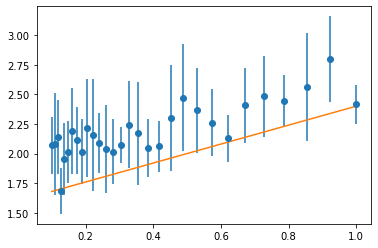

In [5]:
xGrid = np.logspace(-1,-0.0000000001,30)
theoryParams = [0.8, 1.6]
stats = np.array([0.1 for i in range(len(xGrid))])
#syst1= abs(np.array([0.34, 0.30, 0.42, 0.69,0.54, 0.20, 0.25, 0.12, -0.4, -0.12, 0.56, 0.53, 0.34,0.25,  0.45, 0.23, 0.31, 0.23, 0.42, -0.31])) #this is the original systematic error 
syst1 = [np.random.normal(0.3, 0.1) for i in range(len(xGrid))]
#syst2 = [np.random.normal(0.3, 0.4) for i in range(len(xGrid))]
systFluct = [0.8]
dataGen = DatasetGenerator(theoryParams, theory, xGrid, stats, systFluct, syst1)

## Fitting with correlation is NOT ignored 

Parameter at minimum :  [0.6921343  1.66781487]
Chisqr at minimum :  25.846360419817124
Chisqr per dof :  0.9230843007077544
Parameter error using hessian method : 
 [0.0701057  0.06505823]


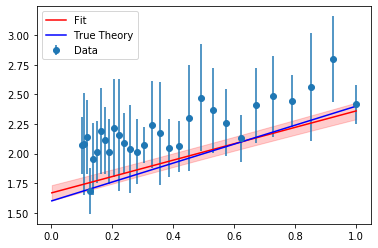

In [6]:
chi2 = ChiSquareCorr(dataGen, theory)
globalanalysis = GlobalAnalysis(1, chi2)
bound = [(-5,5), (-5,5)]
globalanalysis.runFit(bound)
#theoryParams = [0.8, 1.6]

### Repeat the fits for N = 500 times

Mean parAtmin : 
 [0.80000001 1.59951957]
std parAtmin : 
 [0.06678037 0.06329863]
Mean funAtmin : 
 28.131398713058953
std funAtmin : 
 7.390930186855002
Mean z : 
 [-0.00379965  0.00743423]
std z : 
 [0.94145486 1.01716972]


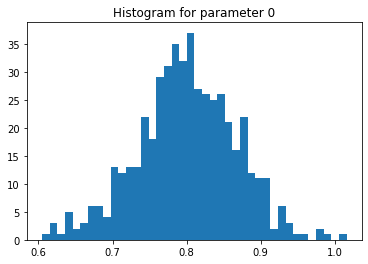

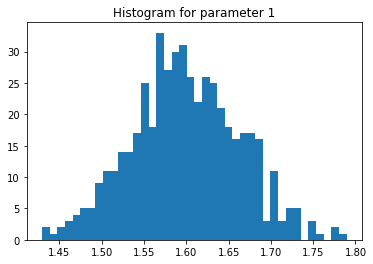

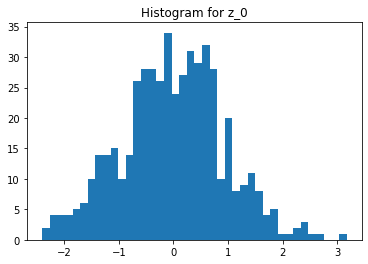

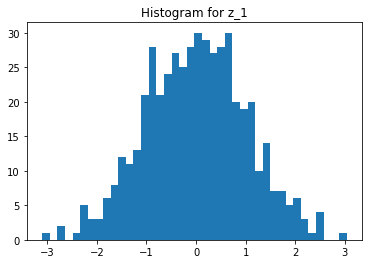

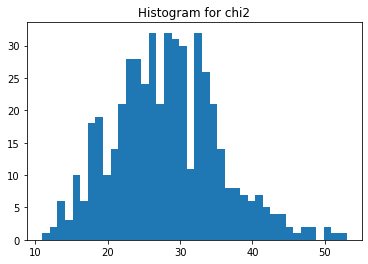

In [7]:
globalanalysis.runReplicaFits(bound, 500)
#theoryParams = [0.8, 1.6]

### The replica is now generated from the data
---

Mean parAtmin : 
 [0.68614551 1.66984464]
std parAtmin : 
 [0.07187243 0.0642262 ]
Mean funAtmin : 
 52.8884932440135
std funAtmin : 
 12.155824343931519
Mean z : 
 [1.60863985 0.42108933]
std z : 
 [1.02144207 0.96883875]


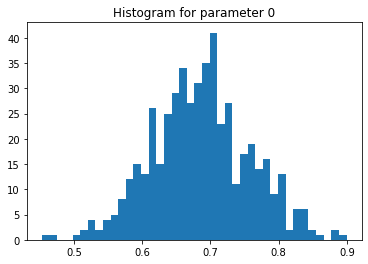

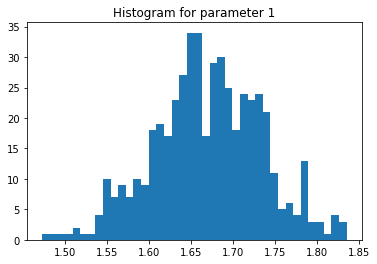

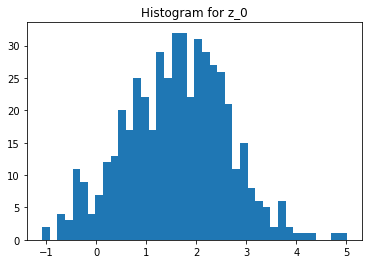

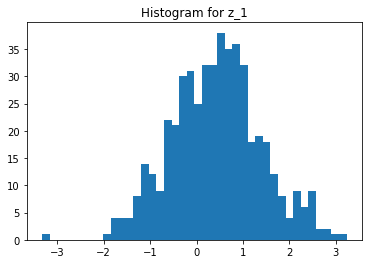

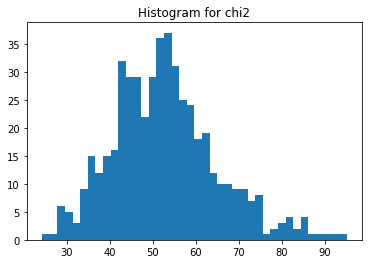

In [8]:
globalanalysis.runReplicaFits(bound, 500, False)
#theoryParams = [0.8, 1.6]

## Fitt with correlation ignored

Parameter at minimum :  [0.67490965 1.93118685]
Chisqr at minimum :  46.88264754610931
Chisqr per dof :  1.674380269503904
Parameter error using hessian method : 
 [0.07110844 0.03375661]


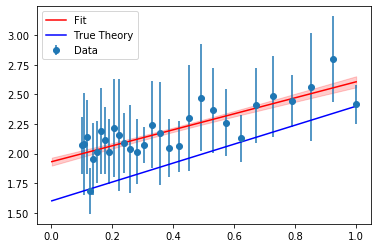

In [9]:
chi2naive = ChiSquareCorr(dataGen, theory, False)
globalnaive = GlobalAnalysis(1, chi2naive)
bound = [(-5,5), (-5,5)]
globalnaive.runFit(bound)

### Repeat the fit for N=500 times

Mean parAtmin : 
 [0.79679901 1.60560569]
std parAtmin : 
 [0.07667269 0.31999068]
Mean funAtmin : 
 56.77719706915582
std funAtmin : 
 42.34225400377326
Mean z : 
 [ 0.06672541 -0.22829777]
std z : 
 [ 2.15374487 16.54732338]


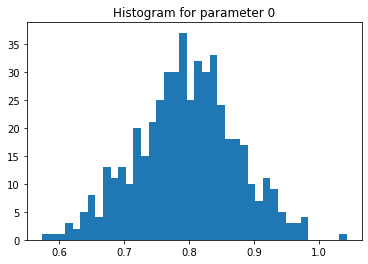

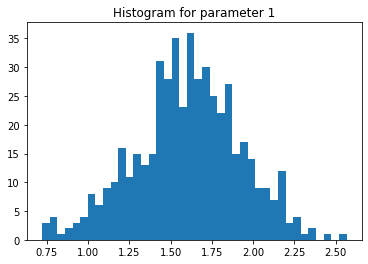

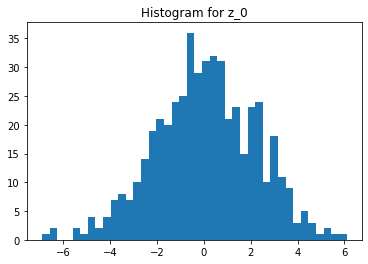

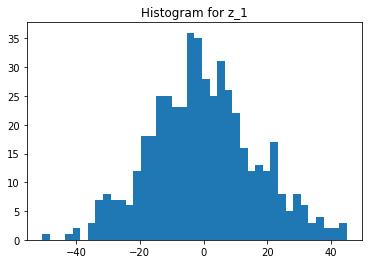

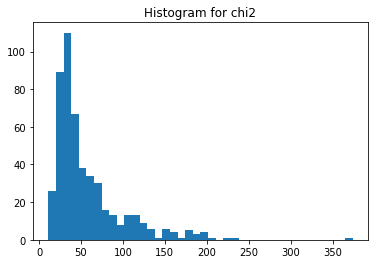

In [10]:
globalnaive.runReplicaFits(bound, 500)
#theoryParams = [0.8, 1.6]

### The replica is now generated from the data

Mean parAtmin : 
 [0.66894894 1.94990441]
std parAtmin : 
 [0.07073804 0.30391196]
Mean funAtmin : 
 105.48694498469372
std funAtmin : 
 72.12040887311025
Mean z : 
 [  3.34005031 -15.80237661]
std z : 
 [ 2.03834719 15.70229551]


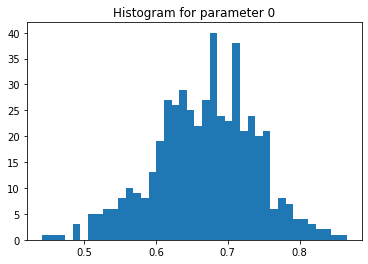

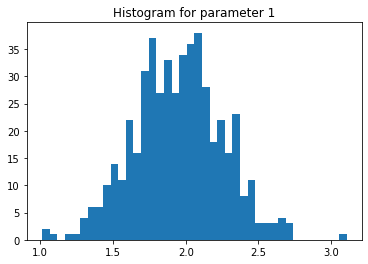

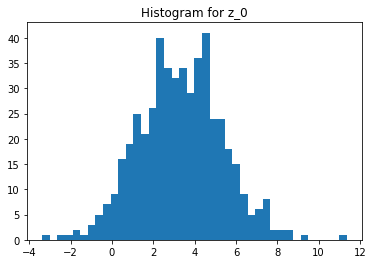

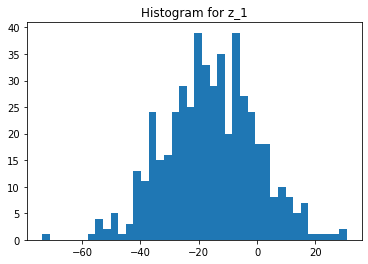

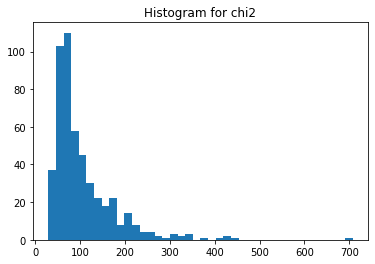

In [11]:
globalnaive.runReplicaFits(bound, 500, False)

---
---
# Fitting Polynomial Curve
--
## Data

In [12]:
def theory (x, params):
    return params[0] + params[1]*x + params[2]* x**4 + params[3] * x**7

Real statistical error :  [ 0.08255906  0.17128763 -0.00304776 -0.11669161  0.05825444  0.00758596
 -0.30269351  0.00237141  0.02426189 -0.09025381  0.05753035  0.1207997
 -0.01846948  0.12242915  0.12079136  0.02680489  0.01049398 -0.24868058
 -0.16596628 -0.02144779]
Real systematic error :  [[ 0.08625121  0.09484522  0.64685583  0.26316487  0.02485894  0.25604683
   0.64261834  0.55003281  0.17726943  0.34981873  0.3006893   0.35086738
   0.34617243  0.15344067  0.27869915  0.36703825  0.11615824 -0.11392922
   0.27398025  0.13509039]]


,x,data,theory,stats,syst_0
0,0.100000,3.129070,2.960260,0.1,0.123216
1,0.112884,3.247168,2.981035,0.1,0.135493
2,0.127427,3.648375,3.004567,0.1,0.924080
3,0.143845,3.177733,3.031259,0.1,0.375950
4,0.162378,3.144711,3.061598,0.1,0.035513
5,0.183298,3.359813,3.096180,0.1,0.365781
6,0.206914,3.475678,3.135753,0.1,0.918026
7,0.233572,3.733684,3.181279,0.1,0.785761
8,0.263665,3.435554,3.234022,0.1,0.253242
9,0.297635,3.555233,3.295668,0.1,0.499741


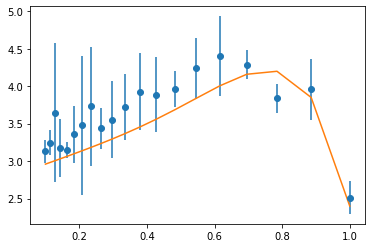

In [13]:
xGrid = np.logspace(-1,-0.0000000001,20)
theoryParams = [2.8, 1.6, 2.6, -4.6  ]
stats = np.array([0.1for i in range(len(xGrid))])
syst1 = [np.random.normal(0.5, 0.3) for i in range(len(xGrid))]
#syst2 = [np.random.normal(0.3, 0.4) for i in range(len(xGrid))]
systFluct = [0.7]
dataGen = DatasetGenerator(theoryParams, theory, xGrid, stats, systFluct, syst1)

##  Fit with correlation NOT ignored

Parameter at minimum :  [ 2.79973282  2.08624845  0.56560422 -3.03283244]
Chisqr at minimum :  18.310794905145688
Chisqr per dof :  1.1444246815716055
Parameter error using hessian method : 
 [0.07295136 0.26077585 0.76226756 0.62070813]


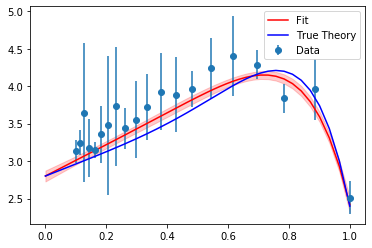

In [14]:
chi2 = ChiSquareCorr(dataGen, theory)
globalPoly = GlobalAnalysis(1, chi2)
bound = [(-5,5), (-5,5), (-5,5), (-5,5)]
globalPoly.runFit(bound)
#theoryParams = [2.8, 1.6, 2.6, -4.6  ]

### Repeat the fit for 200 times

Mean parAtmin : 
 [ 2.79789925  1.63170039  2.50875994 -4.53322762]
std parAtmin : 
 [0.06933072 0.2304447  0.60938665 0.48096868]
Mean funAtmin : 
 16.67736389516249
std funAtmin : 
 5.971747477360661
Mean z : 
 [-0.08527433 -0.04399305  0.03964693  0.11696209]
std z : 
 [0.99440844 0.98834412 0.9455064  0.79096832]


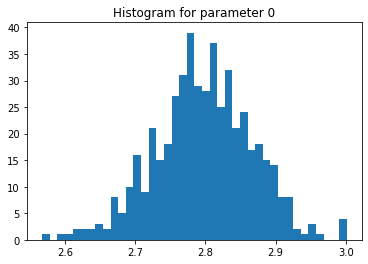

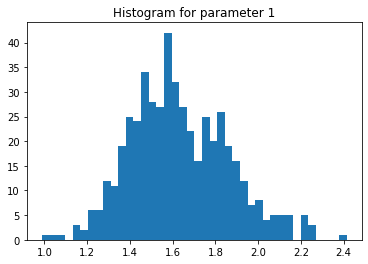

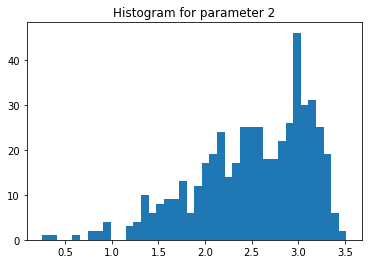

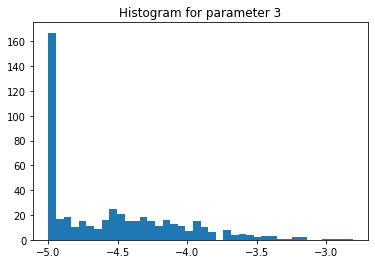

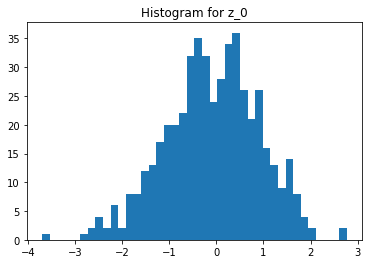

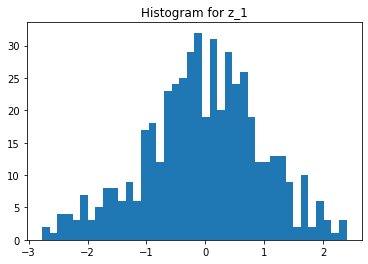

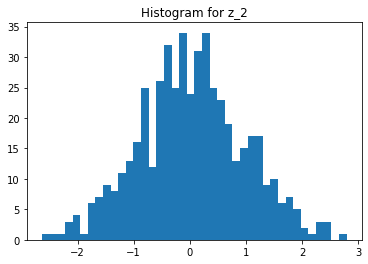

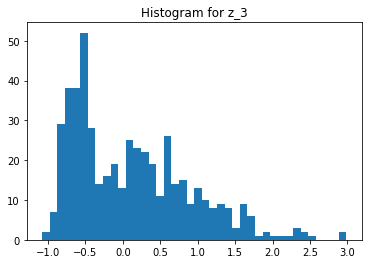

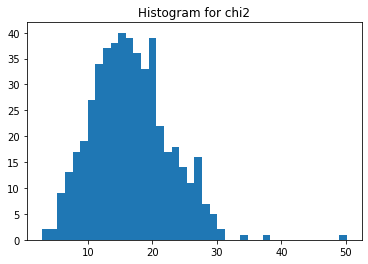

In [15]:
globalPoly.runReplicaFits(bound, 500)
#theoryParams = [2.8, 1.6, 2.6, -4.6  ]

## Ignore Correlation

Parameter at minimum :  [ 2.96119053  2.33736423 -0.67656653 -2.0660298 ]
Chisqr at minimum :  45.90509606269006
Chisqr per dof :  2.869068503918129
Parameter error using hessian method : 
 [0.06719741 0.26383808 0.74673298 0.60776193]


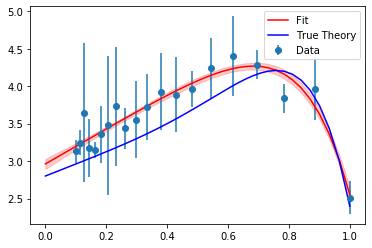

In [16]:
chi2naive = ChiSquareCorr(dataGen, theory, False)
globalPolyNaive = GlobalAnalysis(1, chi2naive)
bound = [(-5,5), (-5,5), (-5,5), (-5,5)]
globalPolyNaive.runFit(bound)
#theoryParams = [2.8, 1.6, 2.6, -4.6  ]

### repeat the fit for 200 times

Mean parAtmin : 
 [ 2.76861384  1.82758575  1.78227257 -3.93100576]
std parAtmin : 
 [0.38347224 0.35290124 1.67461467 1.27458793]
Mean funAtmin : 
 132.7710192082812
std funAtmin : 
 167.31016040576642
Mean z : 
 [-0.17420417 -0.01417577 -0.01376621  1.09948225]
std z : 
 [15.32733621  5.6984568   1.61889377  2.13534854]


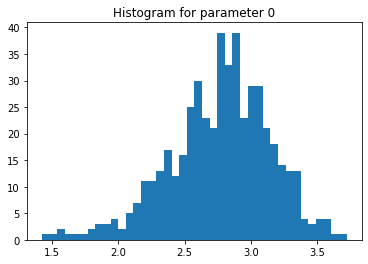

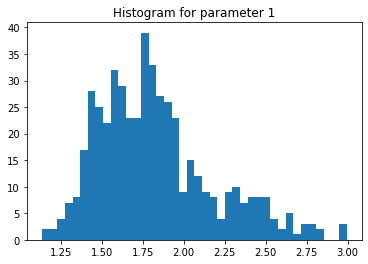

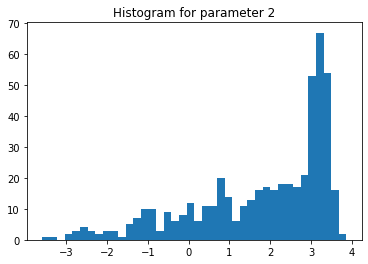

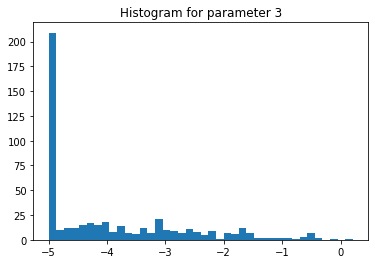

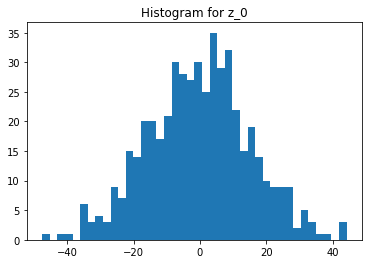

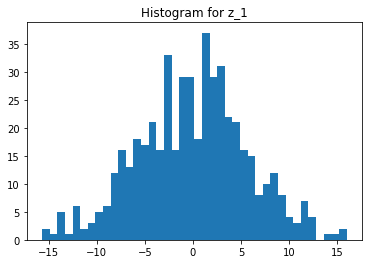

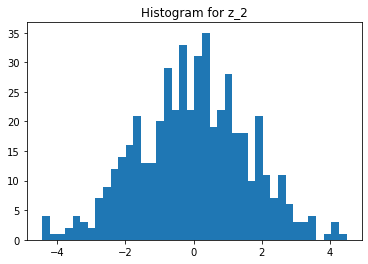

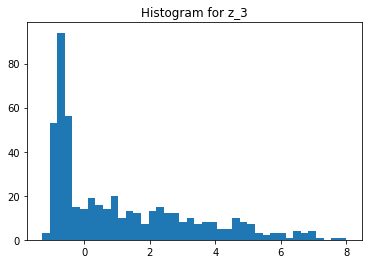

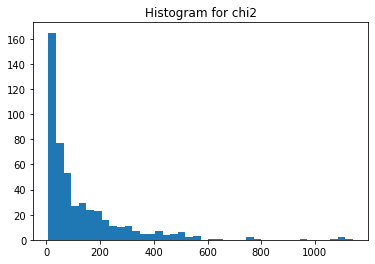

In [17]:
globalPolyNaive.runReplicaFits(bound, 500)
#theoryParams = [2.3, 1.6, 2.6,-4.6  ]

---
---
# Fitting Systematic Fluctuation
---

In [18]:
def theory (x, params):
    return params[0] + params[1]*x + params[2]* x**4 + params[3] * x**7

Real statistical error :  [-0.33123286  0.16172825 -0.03093882 -0.00920092  0.02502854 -0.03701489
 -0.19787998 -0.22797349  0.02759279  0.06908365  0.1007098   0.04640764
 -0.04653798  0.12093567  0.03108881 -0.0038805   0.03454314 -0.02779126
  0.05392067  0.05388247 -0.09126953  0.10506924  0.02944085 -0.01866371
 -0.04375123 -0.05487088  0.01434249  0.07251349  0.06784909  0.08569273]
Real systematic error :  [[ 2.27323773e-01  2.99550307e-01  1.40987343e-02  1.36314940e-01
   3.72787061e-01  4.76588793e-01  4.14027717e-01  5.93602115e-01
   3.63307295e-01  2.45394026e-01  4.43708537e-01  4.30810080e-01
   2.76963276e-01  2.07620188e-01 -1.55563636e-02  5.93276317e-01
   2.55160362e-01  2.96391969e-01  5.77819445e-01  4.43153359e-01
  -3.70862488e-01  4.57368674e-01  1.56950849e-01  2.33773852e-01
   1.17416127e-01  3.10988244e-01  1.74819585e-01  2.01583417e-01
   4.48082940e-01  2.94198806e-01]
 [-1.10486195e-01 -4.05444527e-01  6.05859768e-01  5.62299846e-01
  -2.12721507e-01  1

,x,data,theory,stats,syst_0,syst_1
0,0.100000,2.745864,2.960260,0.1,0.324748,-0.184144
1,0.108264,3.029412,2.973578,0.1,0.427929,-0.675741
2,0.117210,3.577045,2.988026,0.1,0.020141,1.009766
3,0.126896,3.693119,3.003705,0.1,0.194736,0.937166
4,0.137382,3.205828,3.020734,0.1,0.532553,-0.354536
5,0.148735,3.605526,3.039241,0.1,0.680841,0.211185
6,0.161026,3.562790,3.059377,0.1,0.591468,0.478776
7,0.174333,3.338183,3.081312,0.1,0.848003,-0.181262
8,0.188739,3.496463,3.105243,0.1,0.519010,0.000533
9,0.204336,3.881310,3.131402,0.1,0.350563,0.725718


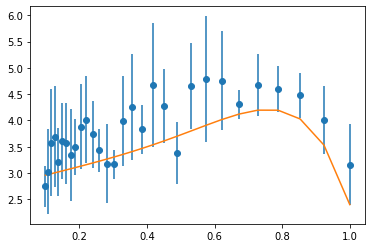

In [19]:
xGrid = np.logspace(-1,-0.0000000001,30)
theoryParams = [2.8, 1.6, 2.6, -4.6  ]
stats = np.array([0.1 for i in range(len(xGrid))])
syst1 = [np.random.normal(0.5, 0.3) for i in range(len(xGrid))]
syst2 = [np.random.normal(0.3, 0.4) for i in range(len(xGrid))]
systFluct = [0.7, 0.6]
dataGen = DatasetGenerator(theoryParams, theory, xGrid, stats, systFluct, syst1, syst2)

## Fit without fitting systematic fluctuations

Parameter at minimum :  [ 2.70655098  1.91489656  1.89995314 -4.01056391]
Chisqr at minimum :  28.692424108196057
Chisqr per dof :  1.103554773392156
Parameter error using hessian method : 
 [0.06303525 0.22202026 0.62587274 0.52478665]


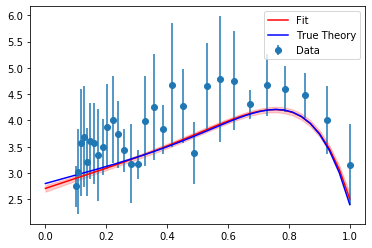

In [20]:
chi2 = ChiSquareCorr(dataGen, theory)
globalAnalysis= GlobalAnalysis(1, chi2)
bound = [(-5,5), (-5,5), (-5,5), (-5,5)]
globalAnalysis.runFit(bound)
#globalAnalysis.getParameterError()
#theoryParams =[2.8, 1.6, 2.6, -4.6  ]

## Fit without fitting systematic fluctuations

Parameter at minimum :  [ 2.70655244  1.91489857  1.89995818 -4.01057379  0.72722139  0.58702545]
Chisqr at minimum :  28.692424117367953
Chisqr per dof :  1.195517671556998
Parameter error using hessian method : 
 [0.06303525 0.22202026 0.62587274 0.52478665 0.0660939  0.04083972]


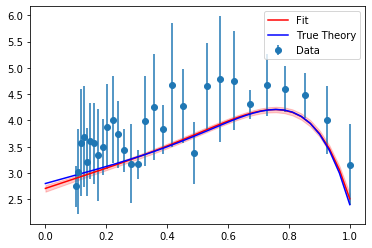

Parameter error using hessian method : 
 [0.06303525 0.22202026 0.62587274 0.52478665 0.0660939  0.04083972]


In [21]:
chi2corrfit =ChiSquareCorrFit(dataGen, theory, 4)
globalAnalysisCorrFit= GlobalAnalysis(1, chi2corrfit)
bound = [(-5,5), (-5,5), (-5,5), (-5,5), (-3,3), (-3,3)]
globalAnalysisCorrFit.runFit(bound)
globalAnalysisCorrFit.getParameterError()
#theoryParams =[2.8, 1.6, 2.6, -4.6, 0.7, 0.6  ]

---
# Theory Imperfection and Correlated Error Fitting
---


In [22]:
def theory (x, params):
    return params[0] + params[1]*x + params[2]* x**4 + params[3] * x**7
def theoryFit (x, params) : 
    return params[0] + params[1]*x + params[2]* x**2 + params[3] * x**3

Real statistical error :  [-2.50308825e-04 -1.54973291e-01  7.74031158e-03 -1.19002782e-01
  5.98334793e-02  1.34183966e-01  1.76929620e-02  8.88649558e-02
 -1.46902053e-01  1.35593086e-01 -4.52928905e-02  7.05012047e-02
  2.08610737e-01 -9.44139746e-02  1.03351714e-02  7.61474920e-02
 -6.89654854e-02  1.41613067e-02  2.04684523e-02 -1.09308693e-04]
Real systematic error :  [[0.25968418 0.26508403 0.44993178 0.29639179 0.59592808 0.52277619
  0.38606708 0.40129034 0.44474836 0.66300064 0.33291463 0.41672192
  0.12784521 0.08956773 0.45309938 0.11384356 0.39851932 0.296103
  0.52860989 0.19268862]]


,x,data,theory,stats,syst_0
0,0.100000,3.219693,2.960260,0.1,0.370977
1,0.112884,3.091146,2.981035,0.1,0.378691
2,0.127427,3.462239,3.004567,0.1,0.642760
3,0.143845,3.208648,3.031259,0.1,0.423417
4,0.162378,3.717360,3.061598,0.1,0.851326
5,0.183298,3.753140,3.096180,0.1,0.746823
6,0.206914,3.539513,3.135753,0.1,0.551524
7,0.233572,3.671435,3.181279,0.1,0.573272
8,0.263665,3.531869,3.234022,0.1,0.635355
9,0.297635,4.094262,3.295668,0.1,0.947144


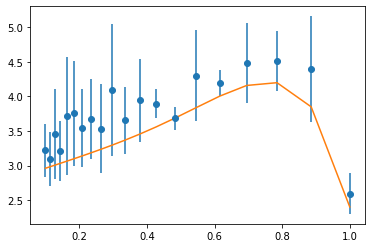

In [23]:
xGrid = np.logspace(-1,-0.0000000001,20)
theoryParams = [2.8, 1.6, 2.6, -4.6  ]
stats = np.array([0.1 for i in range(len(xGrid))])
syst1 = [np.random.normal(0.5, 0.3) for i in range(len(xGrid))]
#syst2 = [np.random.normal(0.3, 0.4) for i in range(len(xGrid))]
systFluct = [0.7]
dataGen = DatasetGenerator(theoryParams, theory, xGrid, stats, systFluct, syst1)

Parameter at minimum :  [ 2.66840959  1.9500079   1.74122328 -3.98352843]
Chisqr at minimum :  15.932753394245834
Chisqr per dof :  0.9957970871403646
Parameter error using hessian method : 
 [0.1008428  0.27145652 0.76021652 0.61867027]


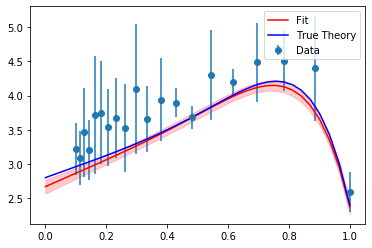

In [24]:
chi2 = ChiSquareCorr(dataGen, theory)
globalanalysis = GlobalAnalysis(1, chi2)
bound = [(-5,5), (-5,5), (-5,5), (-10,10)]
globalanalysis.runFit(bound)
#theoryParams = [2.8, 1.6, 2.6, -4.6  ]

Parameter at minimum :  [  3.03632921  -3.84843443  17.54129796 -14.319034  ]
Chisqr at minimum :  28.617809655773744
Chisqr per dof :  1.788613103485859
Parameter error using hessian method : 
 [0.14144705 1.06450987 2.32378431 1.45111596]


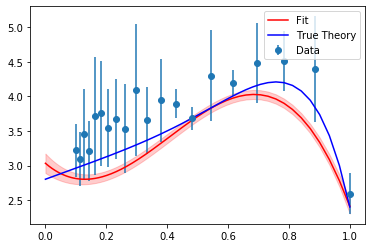

In [25]:
chi2 = ChiSquareCorr(dataGen, theoryFit)
globalanalysis = GlobalAnalysis(1, chi2)
bound = [(-20,20), (-20,20), (-100,100), (-20,20)]
globalanalysis.runFit(bound)
#theoryParams = [2.8, 1.6, 2.6, -4.6  ]

Parameter at minimum :  [  3.0363599   -3.84856174  17.541288   -14.31890175   1.06843719]
Chisqr at minimum :  28.61781006333591
Chisqr per dof :  1.907854004222394
Parameter error using hessian method : 
 [0.14144705 1.06450987 2.3237843  1.45111595 0.10474444]


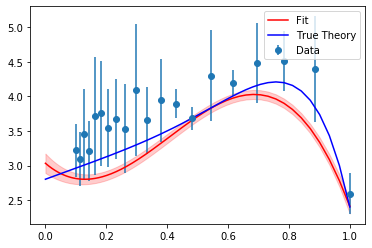

In [26]:
chi2corrfit =ChiSquareCorrFit(dataGen, theoryFit, 4)
globalAnalysisCorrFit= GlobalAnalysis(1, chi2corrfit)
bound = [(-5,5), (-5,5), (-20,20), (-20,20), (-3,3)]
globalAnalysisCorrFit.runFit(bound)
#theoryParams =[2.8, 1.6, 2.6, -4.6, 0.7, 0.6  ]

---
# Global Analysis
---

In [27]:
def theory1 (x, params):
    return (params[0] + params[1] + params[2]+ params[3]) * x**3
def theory2 (x, params) : 
    return (params[0]*params[1])*x + (params[2]*params[3])* x**2 
def theory3 (x, params) : 
    return (params[0]**2+params[1]**2+params[2]**2+params[3]**2) * x**2

theoryParams = [2.8, 1.6, 2.6, -4.6  ]

Real statistical error :  [ 0.12257251 -0.03022398 -0.43235581  0.58575509  0.14733445  0.01415493
 -0.48669529 -0.29077454 -0.34741238 -0.21279694  0.13200392 -0.24497546
 -0.27162744  0.36460485 -0.00965969 -0.13569902  0.06835169 -0.40253463
  0.01773498 -0.33471594 -0.13086975  0.34965809  0.10195094 -0.18438354
 -0.26322973  0.42983808  0.09901217 -0.12536498 -0.00879512 -0.11402403
 -0.50570763  0.71754846 -0.03542754  0.06697332 -0.15317017 -0.05125439
 -0.2968122  -0.29587708 -0.08922225 -0.07428028]
Real systematic error :  [[ 0.18148365 -0.34194797  0.05071646 -0.23640712 -0.35460701 -0.16511358
  -0.29986608 -0.32773095 -0.04884392 -0.11809172 -0.23229995 -0.27773256
  -0.10818357 -0.20268267 -0.0545988   0.05133326  0.07901124  0.09161281
  -0.46149297 -0.22917588 -0.02315144 -0.15293179 -0.44761419 -0.26361638
  -0.12742468  0.12777084 -0.31925085 -0.01565719  0.03070276 -0.24135409
  -0.3492075  -0.27475718 -0.45853514  0.01419786  0.04811722 -0.19661901
  -0.05345754 -0.

,x,data,theory,stats,syst_0,syst_1
0,0.100000,-0.115140,0.002400,0.111989,0.259262,-0.383269
1,0.104219,-0.348555,0.002717,0.235873,-0.488497,0.019000
2,0.108617,0.260445,0.003075,0.370574,0.072452,0.580917
3,0.113200,0.547729,0.003481,0.298934,-0.337724,0.177182
4,0.117976,-0.192040,0.003941,0.155204,-0.506581,0.010265
5,0.122954,-0.244273,0.004461,0.336543,-0.235877,-0.088887
6,0.128142,-0.601376,0.005050,0.277951,-0.428380,0.163760
7,0.133549,-0.290865,0.005717,0.300724,-0.468187,0.292658
8,0.139184,-0.565226,0.006471,0.473183,-0.069777,-0.159492
9,0.145057,-0.622463,0.007325,0.286206,-0.168702,-0.271727


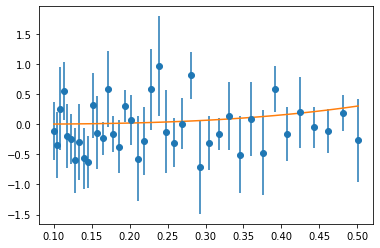

In [28]:
xGrid_1 =  np.logspace(-1,-0.3,40)
stats_1 = np.array([np.random.normal(0.3, 0.1) for i in range(len(xGrid_1))])
syst1_1 = [np.random.normal(-0.2, 0.25) for i in range(len(xGrid_1))]
syst2_1 = [np.random.normal(0.1, 0.3) for i in range(len(xGrid_1))]
systFluct_1 = [0.7, 1.1]
dataGen_1 = DatasetGenerator(theoryParams, theory1, xGrid_1, stats_1, systFluct_1, syst1_1, syst2_1)

Real statistical error :  [ 0.00309219 -0.57469029  0.02896964  0.10340179  0.53482563  0.11549077
  0.52998741 -0.08601182 -0.06413824  0.04812791  0.25884498  0.02723119
  0.08324067 -0.10144696  0.04366351 -0.02726929  0.08859501  0.07458661
  0.27672446  0.08550978]
Real systematic error :  [[-0.02143098 -0.05967868  0.04781546  0.0569412  -0.0131612  -0.02874345
   0.01234549 -0.1080431  -0.03880651  0.04806466 -0.02928407  0.03340326
  -0.09174474 -0.08296996  0.01541489 -0.10159846  0.00366568 -0.01736537
  -0.14796625 -0.02675771]
 [ 0.13745669 -0.07661811  0.31218081  0.01092924 -0.21973934  0.22040366
   0.13996732  0.31781735  0.36357478  0.15293895  0.25626597  0.01764343
   0.31101246  0.07882328  0.1418286   0.09264418 -0.11446269 -0.14788731
   0.35610066  0.11176747]
 [ 0.32311064  0.07775788  0.2423957   0.03197735  0.11146976  0.12614645
   0.34798762  0.29498509  0.29461884  0.03940248  0.28667326  0.32137462
   0.20907171  0.33964516  0.44819748  0.15933722  0.21948

,x,data,theory,stats,syst_0,syst_1,syst_2
0,0.316228,0.662929,0.220700,-0.008452,-0.042862,0.171821,0.269259
1,0.335982,-0.478121,0.155108,0.256306,-0.119357,-0.095773,0.064798
2,0.356970,0.706554,0.075192,0.206044,0.095631,0.390226,0.201996
3,0.379269,0.181989,-0.021261,0.148049,0.113882,0.013662,0.026648
4,0.402961,0.276624,-0.136771,0.242499,-0.026322,-0.274674,0.092891
5,0.428133,0.159089,-0.274208,0.424615,-0.057487,0.275505,0.105122
6,0.454878,0.593451,-0.436837,0.298336,0.024691,0.174959,0.289990
7,0.483293,-0.209623,-0.628370,0.175598,-0.216086,0.397272,0.245821
8,0.513483,-0.297780,-0.853029,0.177603,-0.077613,0.454468,0.245516
9,0.545559,-0.827076,-1.115610,0.097106,0.096129,0.191174,0.032835


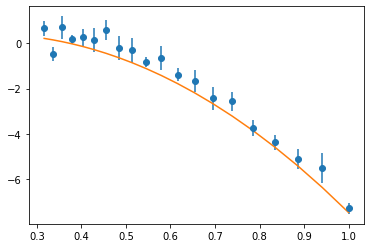

In [29]:
xGrid_2 = np.logspace(-0.5,-0.0000000001,20)
stats_2= np.array([np.random.normal(0.2, 0.1) for i in range(len(xGrid_2))])
syst1_2 = [np.random.normal(-0.05, 0.15) for i in range(len(xGrid_2))]
syst2_2 = [np.random.normal(0.15, 0.2) for i in range(len(xGrid_2))]
syst3_2 = [np.random.normal(0.2, 0.1) for i in range(len(xGrid_2))]
systFluct_2 = [0.5, 0.8, 1.2]
dataGen_2 = DatasetGenerator(theoryParams, theory2, xGrid_2, stats_2, systFluct_2, syst1_2, syst2_2, syst3_2)

Real statistical error :  [-1.20660788  2.01132365 -0.54282884 -0.50830114  0.94964205]
Real systematic error :  []


,x,data,theory,stats
0,0.00,-1.206608,0.000,2.069205
1,0.25,4.406324,2.395,5.524613
2,0.50,9.037171,9.580,-2.285374
3,0.75,21.046699,21.555,-1.042542
4,1.00,39.269642,38.320,-2.233079


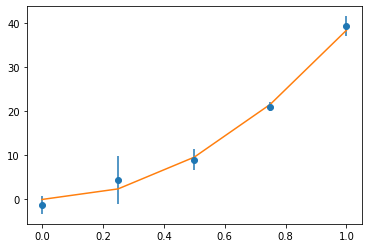

In [30]:
xGrid_3 = np.linspace(0, 1, 5)
stats_3= np.array([np.random.normal(1.5, 5.0) for i in range(len(xGrid_3))])
#syst1_3 = [np.random.normal(-0.05, 0.15) for i in range(len(xGrid_2))]
#syst2_2 = [np.random.normal(0.15, 0.2) for i in range(len(xGrid_2))]
#syst3_2 = [np.random.normal(0.2, 0.1) for i in range(len(xGrid_2))]
systFluct_3= []
dataGen_3 = DatasetGenerator(theoryParams, theory3, xGrid_3, stats_3, systFluct_3)

Parameter at minimum :  [-2.07764514 -2.07776113 -2.33692059  4.99319947]
Chisqr at minimum :  66.51573128037845
Chisqr per dof :  1.090421824268499
Parameter error using hessian method : 
 [0.41697147 0.41699153 0.12876139 0.19203051]


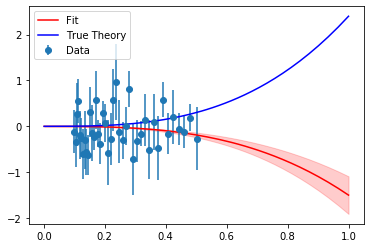

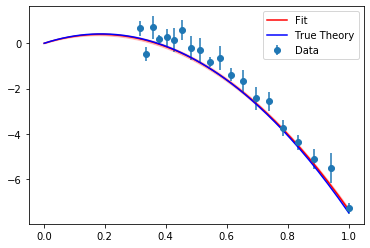

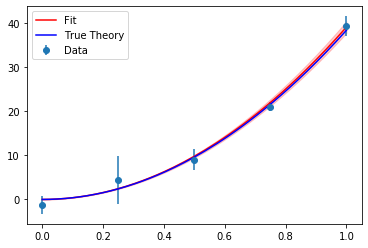

Parameter error using hessian method : 
 [0.41697147 0.41699153 0.12876139 0.19203051]


In [31]:
chi1 = ChiSquareCorr(dataGen_1, theory1)
chi2 = ChiSquareCorr(dataGen_2, theory2)
chi3 = ChiSquareCorr(dataGen_3, theory3)
globalAnalysis = GlobalAnalysis(1, chi1, chi2, chi3)
bound = [(-10,10), (-10,10), (-10,10), (-10,10)]
globalAnalysis.runFit(bound)
globalAnalysis.getParameterError()
#[2.8, 1.6, 2.6, -4.6  ]

Mean parAtmin : 
 [ 0.48032745  0.4561731   0.17841378 -0.06291255]
std parAtmin : 
 [2.18940197 2.17060964 3.89969878 3.70214894]
Mean funAtmin : 
 66.14402382847383
std funAtmin : 
 12.788246457934008
Mean z : 
 [-191.46549586  -17.42601131   -0.24067992    3.20824165]
std z : 
 [374.15702759  68.1709582    2.54958708   7.11280245]


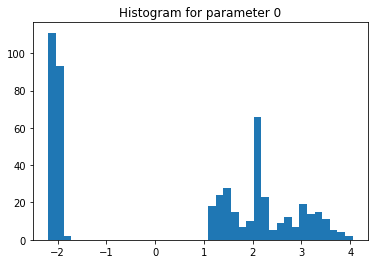

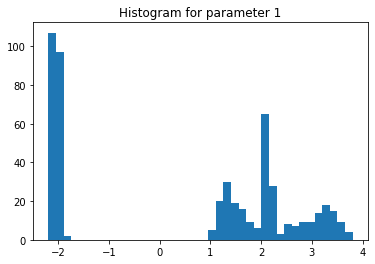

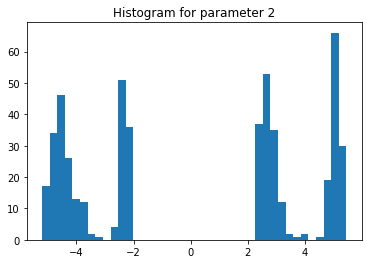

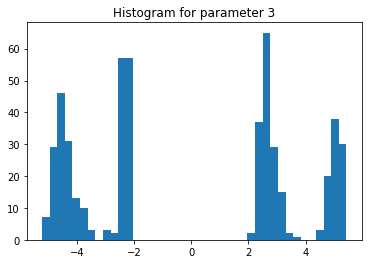

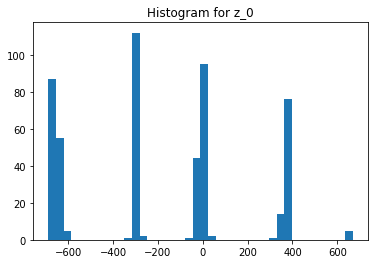

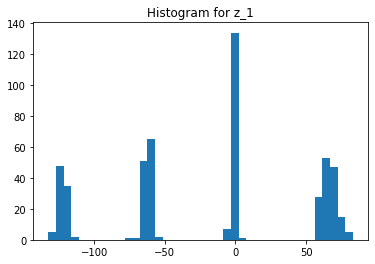

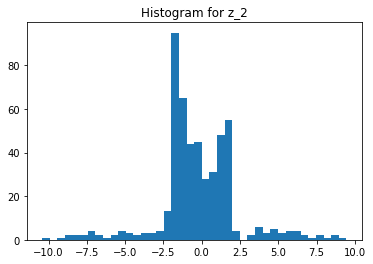

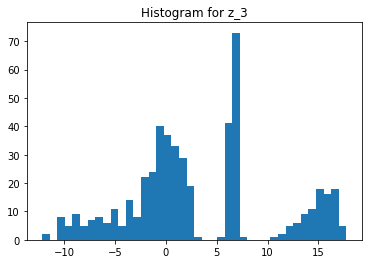

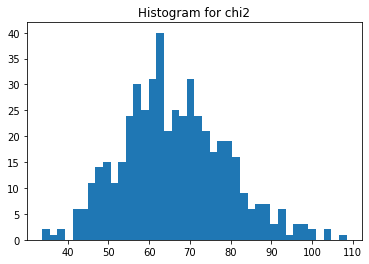

In [32]:
globalAnalysis.runReplicaFits(bound, 500)
#[2.8, 1.6, 2.6, -4.6  ]

### Tensions

In [33]:
def theory1 (x, params):
    return (params[0] + params[1] + params[2]+ params[3]) * x**3
def theory2 (x, params) : 
    return (params[0]*params[1])*x + (params[2]*params[3])* x**2 
def theory3 (x, params) : 
    return (params[0]**2+params[1]**2+params[2]**2+params[3]**2) * x**2

theoryParams1 = [2.8, 1.6, 2.4, -4.3  ]
theoryParams2 = [2.9, 1.6, 2.6, -4.6  ]
theoryParams3 = [2.2, 1.6, 2.5, -3.9  ]

Real statistical error :  [ 0.29254608  0.36199626 -0.00125023 -0.4821604   0.10943045  0.19566899
  0.58142375 -0.25979745 -0.33464054 -0.42865282  0.81660922  0.36997021
 -0.46092616  0.31421268  0.19070778  0.18325723  0.24643086 -0.03958058
  0.63135123 -0.12401198 -0.48292164 -0.48634827  0.83665245 -0.0029897
 -0.47730561 -0.1317697  -0.11675436  0.43211134 -0.1325469  -0.13121356
  0.06787586  0.14335592  0.26150374  0.22772386  0.69202395  0.01572243
  0.43753092  0.26431118 -0.20081291 -0.24541658]
Real systematic error :  [[-0.11648091 -0.12710325 -0.05851613 -0.49577686 -0.08262809 -0.10576069
  -0.28185459 -0.10082685  0.14807886 -0.0418737  -0.10693324 -0.12355951
  -0.24103278 -0.4408668  -0.07948567 -0.24216688 -0.31391268 -0.3729703
   0.14758439 -0.12176999 -0.2368238   0.11515491 -0.13263044 -0.46991417
  -0.31686754 -0.0767606  -0.02454324 -0.17467401 -0.08055964  0.06650721
  -0.05418011  0.08638062 -0.02436566 -0.13724946 -0.57347238 -0.18694547
   0.09991538 -0.34

,x,data,theory,stats,syst_0,syst_1
0,0.100000,0.901935,0.002500,0.339454,-0.166401,0.657609
1,0.104219,0.626571,0.002830,0.419409,-0.181576,0.353498
2,0.108617,0.214252,0.003204,0.136806,-0.083594,0.246195
3,0.113200,-1.321297,0.003626,0.394660,-0.708253,-0.315442
4,0.117976,-0.344612,0.004105,0.308735,-0.118040,-0.341382
5,0.122954,0.463241,0.004647,0.260062,-0.151087,0.335169
6,0.128142,0.603254,0.005260,0.227014,-0.402649,0.271295
7,0.133549,0.103123,0.005955,0.360662,-0.144038,0.416175
8,0.139184,0.056828,0.006741,0.173687,0.211541,0.215136
9,0.145057,-0.589478,0.007631,0.296822,-0.059820,-0.115074


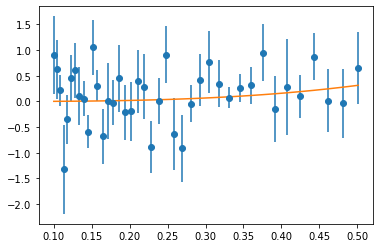

In [34]:
xGrid_1 =  np.logspace(-1,-0.3,40)
stats_1 = np.array([np.random.normal(0.3, 0.1) for i in range(len(xGrid_1))])
syst1_1 = [np.random.normal(-0.2, 0.25) for i in range(len(xGrid_1))]
syst2_1 = [np.random.normal(0.1, 0.3) for i in range(len(xGrid_1))]
systFluct_1 = [0.7, 1.1]
dataGen_1 = DatasetGenerator(theoryParams1, theory1, xGrid_1, stats_1, systFluct_1, syst1_1, syst2_1)

Real statistical error :  [-0.27530318  0.21532976 -0.06025481 -0.4720865   0.16751283 -0.17579609
 -0.1695197   0.16213994 -0.02851514  0.0625568  -0.06323281  0.10101746
 -0.28255743 -0.39199287  0.08945739  0.0934657  -0.22308308  0.32610599
  0.02193897 -0.08959206]
Real systematic error :  [[-0.0841283   0.03029336 -0.02462608  0.05562277  0.07145973 -0.10858388
   0.04481896 -0.04517726 -0.04993642 -0.078951    0.05919761 -0.05651873
  -0.13749279 -0.11397207  0.04234036 -0.08078192 -0.10165941  0.01882172
  -0.06540225 -0.02562493]
 [ 0.01461596 -0.15047281  0.07397567  0.30564013  0.15656624 -0.29123351
  -0.21976446 -0.17766373  0.11110544  0.0550632   0.17238882  0.28419643
   0.21436177 -0.02607935  0.2542376  -0.02357559  0.06491091  0.32238633
   0.15660893  0.10251386]
 [ 0.182873    0.08794559  0.16568548  0.30070169  0.21862986  0.28034371
   0.24930189  0.16723492 -0.03048225  0.1993722   0.30557382  0.31175233
   0.36482393  0.22384774  0.38521907  0.27977994  0.12050

,x,data,theory,stats,syst_0,syst_1,syst_2
0,0.316228,0.109354,0.271297,0.219023,-0.168257,0.018270,0.152394
1,0.335982,0.391961,0.208866,0.165650,0.060587,-0.188091,0.073288
2,0.356970,0.287088,0.132307,0.108457,-0.049252,0.092470,0.138071
3,0.379269,0.229300,0.039422,0.251840,0.111246,0.382050,0.250585
4,0.402961,0.541871,-0.072297,0.150165,0.142919,0.195708,0.182192
5,0.428133,-0.500976,-0.205707,0.237450,-0.217168,-0.364042,0.233620
6,0.454878,-0.459219,-0.364056,0.250972,0.089638,-0.274706,0.207752
7,0.483293,-0.444509,-0.551043,0.174353,-0.090355,-0.222080,0.139362
8,0.513483,-0.768700,-0.770872,0.107401,-0.099873,0.138882,-0.025402
9,0.545559,-0.790279,-1.028320,0.215755,-0.157902,0.068829,0.166144


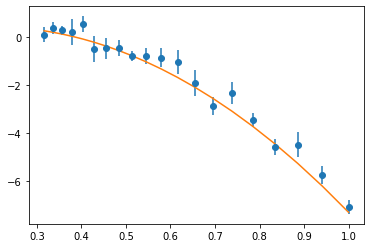

In [35]:
xGrid_2 = np.logspace(-0.5,-0.0000000001,20)
stats_2= np.array([np.random.normal(0.2, 0.1) for i in range(len(xGrid_2))])
syst1_2 = [np.random.normal(-0.05, 0.15) for i in range(len(xGrid_2))]
syst2_2 = [np.random.normal(0.15, 0.2) for i in range(len(xGrid_2))]
syst3_2 = [np.random.normal(0.2, 0.1) for i in range(len(xGrid_2))]
systFluct_2 = [0.5, 0.8, 1.2]
dataGen_2 = DatasetGenerator(theoryParams2, theory2, xGrid_2, stats_2, systFluct_2, syst1_2, syst2_2, syst3_2)

Real statistical error :  [ 5.03090746  0.90468122 -2.25418278 -1.46959489  4.06785155]
Real systematic error :  []


,x,data,theory,stats
0,0.00,5.030907,0.00000,9.023197
1,0.25,2.708431,1.80375,2.762139
2,0.50,4.960817,7.21500,-2.653336
3,0.75,14.764155,16.23375,3.497882
4,1.00,32.927852,28.86000,-2.330112


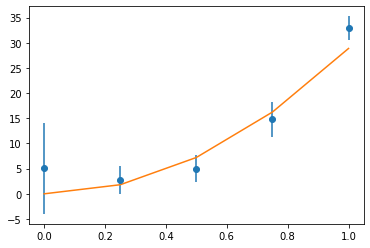

In [36]:
xGrid_3 = np.linspace(0, 1, 5)
stats_3= np.array([np.random.normal(1.5, 5.0) for i in range(len(xGrid_3))])
#syst1_3 = [np.random.normal(-0.05, 0.15) for i in range(len(xGrid_2))]
#syst2_2 = [np.random.normal(0.15, 0.2) for i in range(len(xGrid_2))]
#syst3_2 = [np.random.normal(0.2, 0.1) for i in range(len(xGrid_2))]
systFluct_3= []
dataGen_3 = DatasetGenerator(theoryParams3, theory3, xGrid_3, stats_3, systFluct_3)

Parameter at minimum :  [ 2.15499081  2.15501677 -3.82761656  3.06012689]
Chisqr at minimum :  74.09647164306077
Chisqr per dof :  1.2146962564436192
Parameter error using hessian method : 
 [0.54132802 0.54133346 0.41335642 0.34281813]


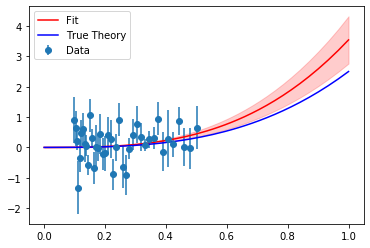

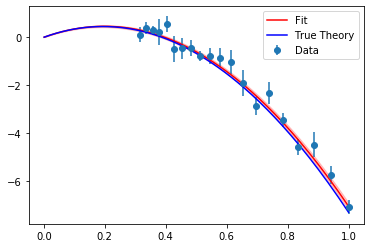

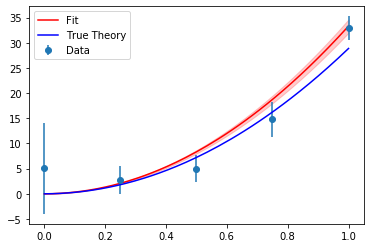

Parameter error using hessian method : 
 [0.54132802 0.54133346 0.41335642 0.34281813]


In [37]:
chi1 = ChiSquareCorr(dataGen_1, theory1)
chi2 = ChiSquareCorr(dataGen_2, theory2)
chi3 = ChiSquareCorr(dataGen_3, theory3)
globalAnalysis = GlobalAnalysis(1, chi1, chi2, chi3)
bound = [(-10,10), (-10,10), (-10,10), (-10,10)]
globalAnalysis.runFit(bound)
globalAnalysis.getParameterError()

Mean parAtmin : 
 [ 0.41882301  0.41692933 -0.02644385  0.33250463]
std parAtmin : 
 [2.05029542 2.04876676 3.4442235  3.52953727]
Mean funAtmin : 
 74.3397035659845
std funAtmin : 
 15.905502596837177
Mean z : 
 [65.8290084  20.84839614 -0.17217586  4.39347775]
std z : 
 [188.44743163  60.46052563   1.77315816   3.83097469]


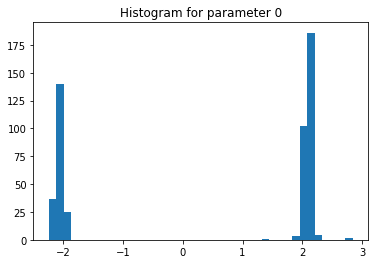

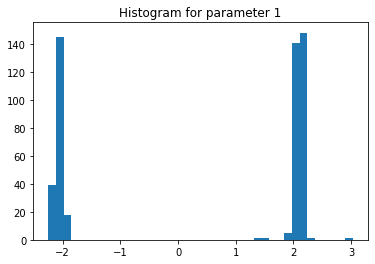

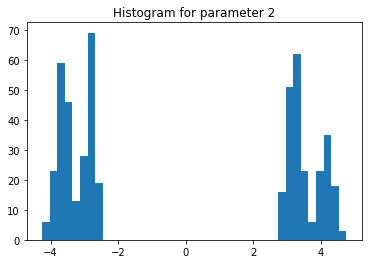

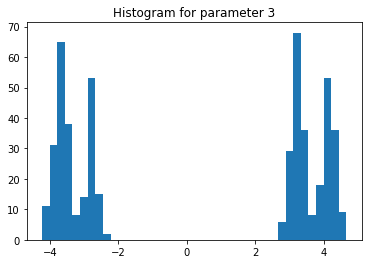

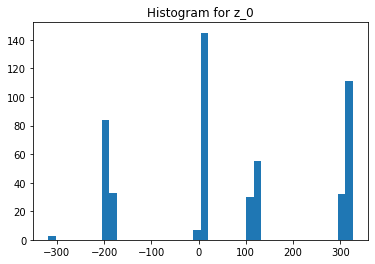

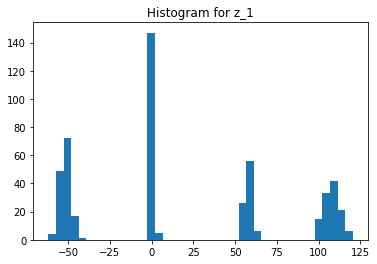

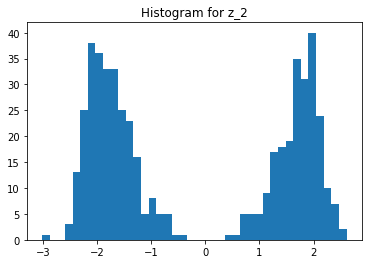

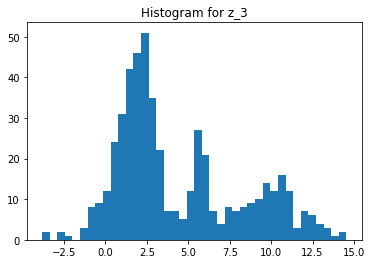

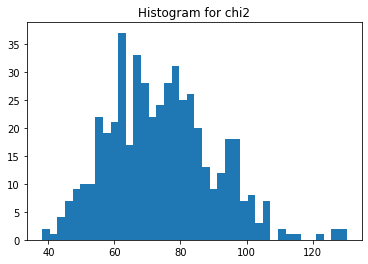

In [38]:
globalAnalysis.runReplicaFits(bound, 500)
#[2.8, 1.6, 2.6, -4.6  ]